In [7]:
#!pip install netCDF4

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset

%matplotlib inline

In [2]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [3]:
#nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'
nc_path  = '//home/hanna/Desktop/examples_master_thesis/'
nc_file  = glob.glob(nc_path + '*.nc')[0]
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan
#d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
#d_theta = lat_array[1:, :] - lat_array[:-1, :]

# Padding the axis -- we removed by taking the difference
#pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values
#d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
#d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

In [4]:
rootgrp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creator_name: EUMETSAT
    creator_url: http://archive.eumetsat.int
    creator_email: archive@eumetsat.int
    institution: EUMETSAT
    license: CopyRight EUMETSAT 2008
    Conventions: CF-1.0
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    summary: NA
    keywords: EUMETSAT, ARCHIVE, NetCDF, CLOUD MASK
    history: EUMETSAT CopyRight 2008
    comment: DRAFT VERSION
    wmo_filename: W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190612113000.nc
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: 0.0
    GRIB_param_Nx: 3712
    GRIB_param_Ny: 3712
    GRIB_orgReferenceTime: 20190612113000
    time_coverage_start: 20190612113000
    time_coverage_end: 20190612113000
    source: /data/products/1338648/MSG4-SEVI-MSGCLMK-0100-0100-20190612113000.000000000Z-20190612114350-1338648.nc.tmp
    dimensions

In [5]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)


In [6]:
def compute_dDegrees(lat, lon):

    d_phi_new2    = np.nan*np.zeros(np.shape(lat))
    d_theta_new2  = np.nan*np.zeros(np.shape(lat))
    cell_areas    = np.nan*np.zeros(np.shape(lat))
    
    count_lon     = 0
    count_lat     = 0
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            left_half_dist     = (lon[i, j] - lon[i, j+1])/2
            right_half_dist    = (lon[i, j-1] - lon[i, j])/2
            
            if lon[i, j] == lon[i, j+1]:
                count_lon += 1
                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon = (np.abs(left_half_dist) + np.abs(right_half_dist))/2
            d_phi_new2[i][j]   = dlon
            
            if lat[i-1, j] == lat[i, j]:
                count_lat += 1
                
            upper_half_dist    = (lat[i+1, j] - lat[i, j])/2
            lower_half_dist    = (lat[i, j] - lat[i-1, j])/2
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat = (np.abs(upper_half_dist) + np.abs(lower_half_dist))/2
            d_theta_new2[i][j] = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat

In [7]:
d_phi_new2, d_theta_new2, cell_areas, count_lon, count_lat = compute_dDegrees(lat_array, lon_array)

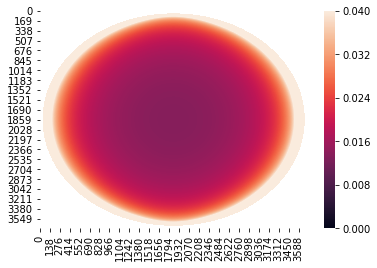

In [8]:
sns.heatmap(d_phi_new2, vmin = 0, vmax = 0.04)

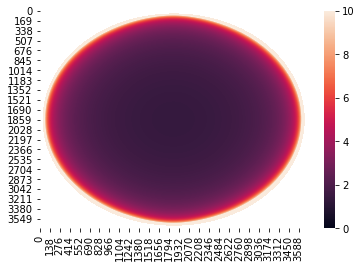

In [9]:
sns.heatmap(cell_areas, vmin = 0, vmax = 10)

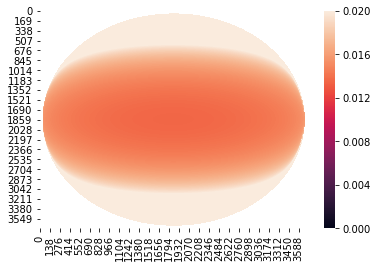

In [10]:
sns.heatmap(d_theta_new2, vmin = 0, vmax = 0.02)

In [11]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(a) - np.abs(b)

In [12]:
def get_centre_centre_cells():
    pass

In [13]:
def compute_area_one_cell(lat = 60, lon = -15, c_lat = None, 
                          c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    era_AREA = area_grid_cell(lat, 0.375, 0.375)
    print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))

    # Make this a loop over lat_lons?
    lat_bondaries = np.array([[lon],
                              [lat]])

    BOUND =  np.array([[-0.75/2, 0.75/2],
                       [-0.75/2, 0.75/2]])

    ranges = lat_bondaries + BOUND

    #lon_range = ranges[0, :]
    #lat_range = ranges[1, :]
    #min_lon, max_lon = lon_range
    #min_lat, max_lat = lat_range

    era_up    = ranges[1, 1]
    era_down  = ranges[1, 0]
    era_left  = ranges[0, 0]
    era_right = ranges[0, 1]

    # to ensure correct sign
    cmk_left  = c_lon - np.abs(d_phi)   #- era_right
    cmk_right = c_lon + np.abs(d_phi)   #- era_left

    # TODO : Sjekk d theta og lignende.
    cmk_up    = c_lat + np.abs(d_theta) #- era_down
    cmk_down  = c_lat - np.abs(d_theta) #- era_up

    idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
    idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
    idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
    idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )
    
    idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
    idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
    idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
    idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

    corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                         idx_upper_left_corner, idx_upper_right_corner]) # corner idx
  
    #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
    
    # TODO add new centre corners. And calculate  
    llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
    llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
    llc_lat  = era_down + llc_dlat
    f = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
    #print("area lower left area {}".format(f/era_AREA))
    
    lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
    lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
    lrc_lat  = era_down + lrc_dlat
    h = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
    #print("area lower right area {}".format(h/era_AREA))
    
    ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
    ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
    ulc_lat = era_up - ulc_dlat
    i = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
    #print("area upper left area {}".format(i/era_AREA))
    
    urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
    urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
    urc_lat  = era_up - ulc_dlat
    j = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
    #print("area upper right area {}".format(j/era_AREA))
    
    #print("SUM corners {}".format((i+j+h+f)/era_AREA))

    if len(corner_idx) == 0:
        raise ValueError('No corners found, something is wrong ... ')
    
    #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
    #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

    # removes corners
    for idx in corner_idx:
        idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]
        
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

    #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
    #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

    #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
    #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]
    
    # subsection left boundary OLD
    low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
    up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
    sub_section_left = np.intersect1d(low_bound, up_bound)

    # subsection right boundary
    low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
    up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
    sub_section_right = np.intersect1d(low_bound, up_bound)

    # Subsection Down Boundary
    one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
    two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
    sub_section_down = np.intersect1d(one, two)

    # subsection up boundary
    one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
    two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
    sub_section_up = np.intersect1d(one, two)
    
    #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
    #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
    #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
    #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
    #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
    #plt.show()
    
    # test that these are empty
    t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
    t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
    assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

    # Calculate Boundaries

    # AREA left boundary
    dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
    dlat_lf = d_theta[idx_left_boundary][sub_section_left]
    lat_lf  = c_lat[idx_left_boundary][sub_section_left]
    #lon_lf  = c_lon[idx_left_boundary][sub_section_left]

    a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

    fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                          dlat_lf,
                                                                                          dlon_lf)/era_AREA).sum()
    # AREA right boundary
    dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
    dlat_rb = d_theta[idx_right_boundary][sub_section_right]
    lat_rb  = c_lat[idx_right_boundary][sub_section_right]
    #lon_rb = c_lon[idx_right_boundary][sub_section_right]

    b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

    fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                             dlat_rb,
                                                                                             dlon_rb)/era_AREA).sum()

    # AREA down boundary
    dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
    lat_down = era_down + dlat_down
    dlon_down = d_phi[idx_down_boundary][sub_section_down]
    #lon_down =  c_lon[idx_down_boundary][sub_section_down]

    c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

    fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                          dlat_down,
                                                                                          dlon_down)/era_AREA).sum()
    # AREA up
    dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
    lat_up = era_up - dlat_up
    #lon_up = c_lon[idx_up_boundary][sub_section_up]
    dlon_up = d_phi[idx_up_boundary][sub_section_up]

    d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

    fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                 dlat_up,
                                                                 dlon_up)/era_AREA).sum()
    # Index centres. Can safly assume centre cells are correct.
    idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                    np.argwhere(cmk_right < era_right))


    idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                    np.argwhere(cmk_down >  era_down))

    idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
    lat_centre_cells = c_lat[idx_centre_cells]
    dlat_centre      = d_theta[idx_centre_cells]
    dlon_centre      = d_phi[idx_centre_cells]
    
    #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
    #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
    #plt.show()
    
    fraction_centre  = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                 dlat_centre,
                                                                 dlon_centre)/era_AREA).sum()
    #print("era_AREA {}".format(era_AREA))
    #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
    #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
    #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
    #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
    #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))
    
    Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                   area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                   area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA + (i+j+h+f)/era_AREA
    
    print("SUM weight {}".format(Test_weight[0]))
    return Test_weight[0]


In [14]:
areas = []
lats = np.arange(30, 56, 0.75)
lons = np.arange(-15, 30, 0.75)
for la in lats:
    for lo in lons:
        area = compute_area_one_cell(lat = la, lon = lo, c_lat = lat_array.reshape(-1), 
                              c_lon = lon_array.reshape(-1), d_theta = d_theta_new2.reshape(-1), 
                              d_phi = d_phi_new2.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1)  )
        areas.append(area)

lat = 945.3930343633116, lon =30.0 era_AREA -15.0


/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/

SUM weight 1.0048204157112952
lat = 945.3930343633116, lon =30.0 era_AREA -14.25
SUM weight 1.0043363871733364
lat = 945.3930343633116, lon =30.0 era_AREA -13.5
SUM weight 1.0039061554818511
lat = 945.3930343633116, lon =30.0 era_AREA -12.75
SUM weight 1.003457255109279
lat = 945.3930343633116, lon =30.0 era_AREA -12.0
SUM weight 1.0030906089839744
lat = 945.3930343633116, lon =30.0 era_AREA -11.25
SUM weight 1.00269289920455
lat = 945.3930343633116, lon =30.0 era_AREA -10.5
SUM weight 1.0023648315104243
lat = 945.3930343633116, lon =30.0 era_AREA -9.75
SUM weight 1.0020237741027895
lat = 945.3930343633116, lon =30.0 era_AREA -9.0
SUM weight 1.0017250443664645
lat = 945.3930343633116, lon =30.0 era_AREA -8.25
SUM weight 1.0014644300148792
lat = 945.3930343633116, lon =30.0 era_AREA -7.5
SUM weight 1.0011967701594369
lat = 945.3930343633116, lon =30.0 era_AREA -6.75
SUM weight 1.0009681003296182
lat = 945.3930343633116, lon =30.0 era_AREA -6.0
SUM weight 1.0007766191785885
lat = 945.393

SUM weight 1.0066967251002419
lat = 938.1674389344815, lon =30.75 era_AREA 18.0
SUM weight 1.0073212549109853
lat = 938.1674389344815, lon =30.75 era_AREA 18.75
SUM weight 1.008036579945249
lat = 938.1674389344815, lon =30.75 era_AREA 19.5
SUM weight 1.008582855171502
lat = 938.1674389344815, lon =30.75 era_AREA 20.25
SUM weight 1.0092799863383042
lat = 938.1674389344815, lon =30.75 era_AREA 21.0
SUM weight 1.0099992426374702
lat = 938.1674389344815, lon =30.75 era_AREA 21.75
SUM weight 1.0107978223604672
lat = 938.1674389344815, lon =30.75 era_AREA 22.5
SUM weight 1.01159615503371
lat = 938.1674389344815, lon =30.75 era_AREA 23.25
SUM weight 1.0123594462459726
lat = 938.1674389344815, lon =30.75 era_AREA 24.0
SUM weight 1.0131720825833652
lat = 938.1674389344815, lon =30.75 era_AREA 24.75
SUM weight 1.0140236869250339
lat = 938.1674389344815, lon =30.75 era_AREA 25.5
SUM weight 1.014915454270825
lat = 938.1674389344815, lon =30.75 era_AREA 26.25
SUM weight 1.0158439897383922
lat = 938

SUM weight 1.0005171106588988
lat = 923.2352632062132, lon =32.25 era_AREA 5.25
SUM weight 1.0006918132660825
lat = 923.2352632062132, lon =32.25 era_AREA 6.0
SUM weight 1.0008868301264928
lat = 923.2352632062132, lon =32.25 era_AREA 6.75
SUM weight 1.001123053233925
lat = 923.2352632062132, lon =32.25 era_AREA 7.5
SUM weight 1.0014336575347786
lat = 923.2352632062132, lon =32.25 era_AREA 8.25
SUM weight 1.0016700846174498
lat = 923.2352632062132, lon =32.25 era_AREA 9.0
SUM weight 1.001997085917872
lat = 923.2352632062132, lon =32.25 era_AREA 9.75
SUM weight 1.0024029564433847
lat = 923.2352632062132, lon =32.25 era_AREA 10.5
SUM weight 1.0027058902082262
lat = 923.2352632062132, lon =32.25 era_AREA 11.25
SUM weight 1.0031869296924893
lat = 923.2352632062132, lon =32.25 era_AREA 12.0
SUM weight 1.0035444339511599
lat = 923.2352632062132, lon =32.25 era_AREA 12.75
SUM weight 1.0040981188920817
lat = 923.2352632062132, lon =32.25 era_AREA 13.5
SUM weight 1.004479251234184
lat = 923.2352

SUM weight 1.0018614062007407
lat = 907.6703481451863, lon =33.75 era_AREA -7.5
SUM weight 1.0015218829370063
lat = 907.6703481451863, lon =33.75 era_AREA -6.75
SUM weight 1.0012644924444039
lat = 907.6703481451863, lon =33.75 era_AREA -6.0
SUM weight 1.000991535048886
lat = 907.6703481451863, lon =33.75 era_AREA -5.25
SUM weight 1.000750956896115
lat = 907.6703481451863, lon =33.75 era_AREA -4.5
SUM weight 1.0005560862716787
lat = 907.6703481451863, lon =33.75 era_AREA -3.75
SUM weight 1.0003951462286833
lat = 907.6703481451863, lon =33.75 era_AREA -3.0
SUM weight 1.0002532674516014
lat = 907.6703481451863, lon =33.75 era_AREA -2.25
SUM weight 1.000144367540262
lat = 907.6703481451863, lon =33.75 era_AREA -1.5
SUM weight 1.0000636830872909
lat = 907.6703481451863, lon =33.75 era_AREA -0.75
SUM weight 1.0000186778098747
lat = 907.6703481451863, lon =33.75 era_AREA 0.0
SUM weight 1.00000225120875
lat = 907.6703481451863, lon =33.75 era_AREA 0.75
SUM weight 1.0000186810768017
lat = 907.6

SUM weight 1.0168524999005064
lat = 899.6539301906819, lon =34.5 era_AREA 24.75
SUM weight 1.01796712618426
lat = 899.6539301906819, lon =34.5 era_AREA 25.5
SUM weight 1.0190903767819692
lat = 899.6539301906819, lon =34.5 era_AREA 26.25
SUM weight 1.0202700615327873
lat = 899.6539301906819, lon =34.5 era_AREA 27.0
SUM weight 1.021494139968221
lat = 899.6539301906819, lon =34.5 era_AREA 27.75
SUM weight 1.0227672638606875
lat = 899.6539301906819, lon =34.5 era_AREA 28.5
SUM weight 1.0240358475076774
lat = 899.6539301906819, lon =34.5 era_AREA 29.25
SUM weight 1.0254845802451884
lat = 891.4833611666762, lon =35.25 era_AREA -15.0
SUM weight 1.0068159145517335
lat = 891.4833611666762, lon =35.25 era_AREA -14.25
SUM weight 1.0060784337264062
lat = 891.4833611666762, lon =35.25 era_AREA -13.5
SUM weight 1.0055274166317485
lat = 891.4833611666762, lon =35.25 era_AREA -12.75
SUM weight 1.004849050076977
lat = 891.4833611666762, lon =35.25 era_AREA -12.0
SUM weight 1.0043709947071948
lat = 891.

SUM weight 1.0039977842137728
lat = 883.1600410580949, lon =36.0 era_AREA 12.0
SUM weight 1.0045148100525514
lat = 883.1600410580949, lon =36.0 era_AREA 12.75
SUM weight 1.0051507842054168
lat = 883.1600410580949, lon =36.0 era_AREA 13.5
SUM weight 1.0057305894667492
lat = 883.1600410580949, lon =36.0 era_AREA 14.25
SUM weight 1.006432335292366
lat = 883.1600410580949, lon =36.0 era_AREA 15.0
SUM weight 1.0070793891066416
lat = 883.1600410580949, lon =36.0 era_AREA 15.75
SUM weight 1.0078294525634923
lat = 883.1600410580949, lon =36.0 era_AREA 16.5
SUM weight 1.0086687132625627
lat = 883.1600410580949, lon =36.0 era_AREA 17.25
SUM weight 1.0093912044030195
lat = 883.1600410580949, lon =36.0 era_AREA 18.0
SUM weight 1.0102579706658867
lat = 883.1600410580949, lon =36.0 era_AREA 18.75
SUM weight 1.0111472619278934
lat = 883.1600410580949, lon =36.0 era_AREA 19.5
SUM weight 1.012165280406291
lat = 883.1600410580949, lon =36.0 era_AREA 20.25
SUM weight 1.0130389368034813
lat = 883.16004105

SUM weight 1.0000235480478463
lat = 866.0608781481993, lon =37.5 era_AREA 0.0
SUM weight 1.0000041161011852
lat = 866.0608781481993, lon =37.5 era_AREA 0.75
SUM weight 1.0000235508696336
lat = 866.0608781481993, lon =37.5 era_AREA 1.5
SUM weight 1.000083400775839
lat = 866.0608781481993, lon =37.5 era_AREA 2.25
SUM weight 1.0001776285002477
lat = 866.0608781481993, lon =37.5 era_AREA 3.0
SUM weight 1.00030915313571
lat = 866.0608781481993, lon =37.5 era_AREA 3.75
SUM weight 1.00048631157614
lat = 866.0608781481993, lon =37.5 era_AREA 4.5
SUM weight 1.000699376532486
lat = 866.0608781481993, lon =37.5 era_AREA 5.25
SUM weight 1.0009636358066663
lat = 866.0608781481993, lon =37.5 era_AREA 6.0
SUM weight 1.0012659110156943
lat = 866.0608781481993, lon =37.5 era_AREA 6.75
SUM weight 1.0015437105078082
lat = 866.0608781481993, lon =37.5 era_AREA 7.5
SUM weight 1.0019158723735473
lat = 866.0608781481993, lon =37.5 era_AREA 8.25
SUM weight 1.0024032628839865
lat = 866.0608781481993, lon =37.5

SUM weight 1.0061433263241977
lat = 848.3681603731322, lon =39.0 era_AREA -12.0
SUM weight 1.0053593810316273
lat = 848.3681603731322, lon =39.0 era_AREA -11.25
SUM weight 1.0047983467108441
lat = 848.3681603731322, lon =39.0 era_AREA -10.5
SUM weight 1.004107719912826
lat = 848.3681603731322, lon =39.0 era_AREA -9.75
SUM weight 1.0035850988500084
lat = 848.3681603731322, lon =39.0 era_AREA -9.0
SUM weight 1.0030744076116505
lat = 848.3681603731322, lon =39.0 era_AREA -8.25
SUM weight 1.0024927740322427
lat = 848.3681603731322, lon =39.0 era_AREA -7.5
SUM weight 1.0021463805600717
lat = 848.3681603731322, lon =39.0 era_AREA -6.75
SUM weight 1.001722990014485
lat = 848.3681603731322, lon =39.0 era_AREA -6.0
SUM weight 1.0013253163104798
lat = 848.3681603731322, lon =39.0 era_AREA -5.25
SUM weight 1.001045224080786
lat = 848.3681603731322, lon =39.0 era_AREA -4.5
SUM weight 1.0007751994999008
lat = 848.3681603731322, lon =39.0 era_AREA -3.75
SUM weight 1.0005373290103918
lat = 848.368160

SUM weight 1.016174512820848
lat = 839.3029920289711, lon =39.75 era_AREA 21.0
SUM weight 1.0174407446057865
lat = 839.3029920289711, lon =39.75 era_AREA 21.75
SUM weight 1.0163947836200178
lat = 839.3029920289711, lon =39.75 era_AREA 22.5
SUM weight 1.019676715959689
lat = 839.3029920289711, lon =39.75 era_AREA 23.25
SUM weight 1.021612098790166
lat = 839.3029920289711, lon =39.75 era_AREA 24.0
SUM weight 1.0230613990941548
lat = 839.3029920289711, lon =39.75 era_AREA 24.75
SUM weight 1.024582228445801
lat = 839.3029920289711, lon =39.75 era_AREA 25.5
SUM weight 1.0261465809362869
lat = 839.3029920289711, lon =39.75 era_AREA 26.25
SUM weight 1.027753009100577
lat = 839.3029920289711, lon =39.75 era_AREA 27.0
SUM weight 1.0294783028019796
lat = 839.3029920289711, lon =39.75 era_AREA 27.75
SUM weight 1.0313057141132695
lat = 839.3029920289711, lon =39.75 era_AREA 28.5
SUM weight 1.0331442622095321
lat = 839.3029920289711, lon =39.75 era_AREA 29.25
SUM weight 1.035002309682139
lat = 830.

SUM weight 1.0024155427572359
lat = 820.7428025109152, lon =41.25 era_AREA 8.25
SUM weight 1.0029269258250213
lat = 820.7428025109152, lon =41.25 era_AREA 9.0
SUM weight 1.0034009493578635
lat = 820.7428025109152, lon =41.25 era_AREA 9.75
SUM weight 1.0040782180581977
lat = 820.7428025109152, lon =41.25 era_AREA 10.5
SUM weight 1.0046420646856358
lat = 820.7428025109152, lon =41.25 era_AREA 11.25
SUM weight 1.0054444839077563
lat = 820.7428025109152, lon =41.25 era_AREA 12.0
SUM weight 1.003279198747026
lat = 820.7428025109152, lon =41.25 era_AREA 12.75
SUM weight 1.0069264737475987
lat = 820.7428025109152, lon =41.25 era_AREA 13.5
SUM weight 1.0077119868705895
lat = 820.7428025109152, lon =41.25 era_AREA 14.25
SUM weight 1.0087721448811522
lat = 820.7428025109152, lon =41.25 era_AREA 15.0
SUM weight 1.0095657465465366
lat = 820.7428025109152, lon =41.25 era_AREA 15.75
SUM weight 1.010565340278411
lat = 820.7428025109152, lon =41.25 era_AREA 16.5
SUM weight 1.0117979729706552
lat = 820

SUM weight 1.0013186408506938
lat = 801.6201168730207, lon =42.75 era_AREA -4.5
SUM weight 1.0009490765055642
lat = 801.6201168730207, lon =42.75 era_AREA -3.75
SUM weight 1.0006640245962939
lat = 801.6201168730207, lon =42.75 era_AREA -3.0
SUM weight 1.0004218148225539
lat = 801.6201168730207, lon =42.75 era_AREA -2.25
SUM weight 1.0002388363846302
lat = 801.6201168730207, lon =42.75 era_AREA -1.5
SUM weight 1.0001119746604823
lat = 801.6201168730207, lon =42.75 era_AREA -0.75
SUM weight 1.0000318853783792
lat = 801.6201168730207, lon =42.75 era_AREA 0.0
SUM weight 1.0000065371042537
lat = 801.6201168730207, lon =42.75 era_AREA 0.75
SUM weight 1.0000319280009646
lat = 801.6201168730207, lon =42.75 era_AREA 1.5
SUM weight 1.00011199967981
lat = 801.6201168730207, lon =42.75 era_AREA 2.25
SUM weight 1.0002389458986671
lat = 801.6201168730207, lon =42.75 era_AREA 3.0
SUM weight 1.000421931392944
lat = 801.6201168730207, lon =42.75 era_AREA 3.75
SUM weight 1.0006640556764816
lat = 801.620

SUM weight 1.0384294234208988
lat = 791.8519187358421, lon =43.5 era_AREA 28.5
SUM weight 1.0407828763936375
lat = 791.8519187358421, lon =43.5 era_AREA 29.25
SUM weight 1.0431183268016075
lat = 781.9480408488481, lon =44.25 era_AREA -15.0
SUM weight 1.0111838858406013
lat = 781.9480408488481, lon =44.25 era_AREA -14.25
SUM weight 1.0102325012192965
lat = 781.9480408488481, lon =44.25 era_AREA -13.5
SUM weight 1.0092181996632825
lat = 781.9480408488481, lon =44.25 era_AREA -12.75
SUM weight 1.0080711632429669
lat = 781.9480408488481, lon =44.25 era_AREA -12.0
SUM weight 1.007332661190198
lat = 781.9480408488481, lon =44.25 era_AREA -11.25
SUM weight 1.0062452959189816
lat = 781.9480408488481, lon =44.25 era_AREA -10.5
SUM weight 1.005612190303434
lat = 781.9480408488481, lon =44.25 era_AREA -9.75
SUM weight 1.0047362227801409
lat = 781.9480408488481, lon =44.25 era_AREA -9.0
SUM weight 1.004028085326632
lat = 781.9480408488481, lon =44.25 era_AREA -8.25
SUM weight 1.0034924053745096
la

SUM weight 1.0118938205195267
lat = 771.9101801905401, lon =45.0 era_AREA 15.75
SUM weight 1.0129565127516842
lat = 771.9101801905401, lon =45.0 era_AREA 16.5
SUM weight 1.0142889513480804
lat = 771.9101801905401, lon =45.0 era_AREA 17.25
SUM weight 1.015761576882522
lat = 771.9101801905401, lon =45.0 era_AREA 18.0
SUM weight 1.0171492403896356
lat = 771.9101801905401, lon =45.0 era_AREA 18.75
SUM weight 1.0183360099064662
lat = 771.9101801905401, lon =45.0 era_AREA 19.5
SUM weight 1.0201499678351846
lat = 771.9101801905401, lon =45.0 era_AREA 20.25
SUM weight 1.0217903728716007
lat = 771.9101801905401, lon =45.0 era_AREA 21.0
SUM weight 1.0234931951459265
lat = 771.9101801905401, lon =45.0 era_AREA 21.75
SUM weight 1.0252219726231913
lat = 771.9101801905401, lon =45.0 era_AREA 22.5
SUM weight 1.0270359641140538
lat = 771.9101801905401, lon =45.0 era_AREA 23.25
SUM weight 1.0288261016175106
lat = 771.9101801905401, lon =45.0 era_AREA 24.0
SUM weight 1.0308127679319723
lat = 771.9101801

SUM weight 1.0005269807252266
lat = 751.4394129654963, lon =46.5 era_AREA 3.75
SUM weight 1.0008155469849995
lat = 751.4394129654963, lon =46.5 era_AREA 4.5
SUM weight 1.001173099559801
lat = 751.4394129654963, lon =46.5 era_AREA 5.25
SUM weight 1.0016005986783587
lat = 751.4394129654963, lon =46.5 era_AREA 6.0
SUM weight 1.0019988600084868
lat = 751.4394129654963, lon =46.5 era_AREA 6.75
SUM weight 1.0025266155928187
lat = 751.4394129654963, lon =46.5 era_AREA 7.5
SUM weight 1.0032561349322866
lat = 751.4394129654963, lon =46.5 era_AREA 8.25
SUM weight 1.0038497466394125
lat = 751.4394129654963, lon =46.5 era_AREA 9.0
SUM weight 1.0044905445329
lat = 751.4394129654963, lon =46.5 era_AREA 9.75
SUM weight 1.0054999464118064
lat = 751.4394129654963, lon =46.5 era_AREA 10.5
SUM weight 1.0060838113641442
lat = 751.4394129654963, lon =46.5 era_AREA 11.25
SUM weight 1.0072765216865214
lat = 751.4394129654963, lon =46.5 era_AREA 12.0
SUM weight 1.0080293636710742
lat = 751.4394129654963, lon 

SUM weight 1.0058373600722659
lat = 730.453646702073, lon =48.0 era_AREA -9.0
SUM weight 1.0049020283227785
lat = 730.453646702073, lon =48.0 era_AREA -8.25
SUM weight 1.0041978318670284
lat = 730.453646702073, lon =48.0 era_AREA -7.5
SUM weight 1.003441999645074
lat = 730.453646702073, lon =48.0 era_AREA -6.75
SUM weight 1.0027748628656319
lat = 730.453646702073, lon =48.0 era_AREA -6.0
SUM weight 1.0022169473601592
lat = 730.453646702073, lon =48.0 era_AREA -5.25
SUM weight 1.001706521524596
lat = 730.453646702073, lon =48.0 era_AREA -4.5
SUM weight 1.0012520409962442
lat = 730.453646702073, lon =48.0 era_AREA -3.75
SUM weight 1.0008590272561506
lat = 730.453646702073, lon =48.0 era_AREA -3.0
SUM weight 1.000554838488601
lat = 730.453646702073, lon =48.0 era_AREA -2.25
SUM weight 1.0003486355336095
lat = 730.453646702073, lon =48.0 era_AREA -1.5
SUM weight 1.0001858952004075
lat = 730.453646702073, lon =48.0 era_AREA -0.75
SUM weight 1.0000800544331174
lat = 730.453646702073, lon =48

SUM weight 1.0375991983868194
lat = 719.772119972773, lon =48.75 era_AREA 24.75
SUM weight 1.0402662012480772
lat = 719.772119972773, lon =48.75 era_AREA 25.5
SUM weight 1.0428211377143983
lat = 719.772119972773, lon =48.75 era_AREA 26.25
SUM weight 1.0455207408137934
lat = 719.772119972773, lon =48.75 era_AREA 27.0
SUM weight 1.0481803591042722
lat = 719.772119972773, lon =48.75 era_AREA 27.75
SUM weight 1.0474957639143307
lat = 719.772119972773, lon =48.75 era_AREA 28.5
SUM weight 1.052947079432108
lat = 719.772119972773, lon =48.75 era_AREA 29.25
SUM weight 1.057489388815897
lat = 708.9672639961412, lon =49.5 era_AREA -15.0
SUM weight 1.0148585011212408
lat = 708.9672639961412, lon =49.5 era_AREA -14.25
SUM weight 1.0134937500027745
lat = 708.9672639961412, lon =49.5 era_AREA -13.5
SUM weight 1.0122235103892492
lat = 708.9672639961412, lon =49.5 era_AREA -12.75
SUM weight 1.0106434337031756
lat = 708.9672639961412, lon =49.5 era_AREA -12.0
SUM weight 1.0096427255348437
lat = 708.967

SUM weight 1.0099033037838478
lat = 698.0409301285835, lon =50.25 era_AREA 12.75
SUM weight 1.011238930040837
lat = 698.0409301285835, lon =50.25 era_AREA 13.5
SUM weight 1.012546954178706
lat = 698.0409301285835, lon =50.25 era_AREA 14.25
SUM weight 1.0140701650181156
lat = 698.0409301285835, lon =50.25 era_AREA 15.0
SUM weight 1.0155378177265681
lat = 698.0409301285835, lon =50.25 era_AREA 15.75
SUM weight 1.0171905836684745
lat = 698.0409301285835, lon =50.25 era_AREA 16.5
SUM weight 1.0189284328191848
lat = 698.0409301285835, lon =50.25 era_AREA 17.25
SUM weight 1.020653940325083
lat = 698.0409301285835, lon =50.25 era_AREA 18.0
SUM weight 1.0225739640702407
lat = 698.0409301285835, lon =50.25 era_AREA 18.75
SUM weight 1.024532114716353
lat = 698.0409301285835, lon =50.25 era_AREA 19.5
SUM weight 1.0265856754881448
lat = 698.0409301285835, lon =50.25 era_AREA 20.25
SUM weight 1.0286947156763613
lat = 698.0409301285835, lon =50.25 era_AREA 21.0
SUM weight 1.0310118025481745
lat = 69

SUM weight 1.0000791662720452
lat = 675.8313378988103, lon =51.75 era_AREA 0.0
SUM weight 1.0000379245328739
lat = 675.8313378988103, lon =51.75 era_AREA 0.75
SUM weight 1.0000792219953392
lat = 675.8313378988103, lon =51.75 era_AREA 1.5
SUM weight 1.0002105122582412
lat = 675.8313378988103, lon =51.75 era_AREA 2.25
SUM weight 1.0004208889664206
lat = 675.8313378988103, lon =51.75 era_AREA 3.0
SUM weight 1.000717625867098
lat = 675.8313378988103, lon =51.75 era_AREA 3.75
SUM weight 1.0011128175560187
lat = 675.8313378988103, lon =51.75 era_AREA 4.5
SUM weight 1.0015841809758028
lat = 675.8313378988103, lon =51.75 era_AREA 5.25
SUM weight 1.0020101694071393
lat = 675.8313378988103, lon =51.75 era_AREA 6.0
SUM weight 1.0026396043024275
lat = 675.8313378988103, lon =51.75 era_AREA 6.75
SUM weight 1.0033689162817567
lat = 675.8313378988103, lon =51.75 era_AREA 7.5
SUM weight 1.0043620541133431
lat = 675.8313378988103, lon =51.75 era_AREA 8.25
SUM weight 1.004955777527006
lat = 675.83133789

SUM weight 1.012831123706395
lat = 653.1585646285696, lon =53.25 era_AREA -12.0
SUM weight 1.0111058440141865
lat = 653.1585646285696, lon =53.25 era_AREA -11.25
SUM weight 1.005491654154275
lat = 653.1585646285696, lon =53.25 era_AREA -10.5
SUM weight 1.0091569083058067
lat = 653.1585646285696, lon =53.25 era_AREA -9.75
SUM weight 1.0075716704170345
lat = 653.1585646285696, lon =53.25 era_AREA -9.0
SUM weight 1.0064484230540207
lat = 653.1585646285696, lon =53.25 era_AREA -8.25
SUM weight 1.005659823632809
lat = 653.1585646285696, lon =53.25 era_AREA -7.5
SUM weight 1.0044759370239063
lat = 653.1585646285696, lon =53.25 era_AREA -6.75
SUM weight 1.0035510801575496
lat = 653.1585646285696, lon =53.25 era_AREA -6.0
SUM weight 1.002998793117947
lat = 653.1585646285696, lon =53.25 era_AREA -5.25
SUM weight 1.0022899242851613
lat = 653.1585646285696, lon =53.25 era_AREA -4.5
SUM weight 1.0016745849358004
lat = 653.1585646285696, lon =53.25 era_AREA -3.75
SUM weight 1.001146445854564
lat = 

SUM weight 1.0320910072742089
lat = 641.6533288636663, lon =54.0 era_AREA 20.25
SUM weight 1.0354263672787525
lat = 641.6533288636663, lon =54.0 era_AREA 21.0
SUM weight 1.038188309080358
lat = 641.6533288636663, lon =54.0 era_AREA 21.75
SUM weight 1.0405698722815098
lat = 641.6533288636663, lon =54.0 era_AREA 22.5
SUM weight 1.0432365083021244
lat = 641.6533288636663, lon =54.0 era_AREA 23.25
SUM weight 1.0466403952332246
lat = 641.6533288636663, lon =54.0 era_AREA 24.0
SUM weight 1.0502442869418576
lat = 641.6533288636663, lon =54.0 era_AREA 24.75
SUM weight 1.0535578918773427
lat = 641.6533288636663, lon =54.0 era_AREA 25.5
SUM weight 1.0570576835226488
lat = 641.6533288636663, lon =54.0 era_AREA 26.25
SUM weight 1.0606606803152503
lat = 641.6533288636663, lon =54.0 era_AREA 27.0
SUM weight 1.0642975485544661
lat = 641.6533288636663, lon =54.0 era_AREA 27.75
SUM weight 1.068176690516469
lat = 641.6533288636663, lon =54.0 era_AREA 28.5
SUM weight 1.0721107148860145
lat = 641.65332886

SUM weight 1.0041564913135834
lat = 618.3150155511593, lon =55.5 era_AREA 7.5
SUM weight 1.005289815127582
lat = 618.3150155511593, lon =55.5 era_AREA 8.25
SUM weight 1.00615653914142
lat = 618.3150155511593, lon =55.5 era_AREA 9.0
SUM weight 1.007141083175705
lat = 618.3150155511593, lon =55.5 era_AREA 9.75
SUM weight 1.0089398204085456
lat = 618.3150155511593, lon =55.5 era_AREA 10.5
SUM weight 1.0099014404803084
lat = 618.3150155511593, lon =55.5 era_AREA 11.25
SUM weight 1.0114571147466862
lat = 618.3150155511593, lon =55.5 era_AREA 12.0
SUM weight 1.013417078033412
lat = 618.3150155511593, lon =55.5 era_AREA 12.75
SUM weight 1.0144142821464401
lat = 618.3150155511593, lon =55.5 era_AREA 13.5
SUM weight 1.0171559382183621
lat = 618.3150155511593, lon =55.5 era_AREA 14.25
SUM weight 1.018073940881906
lat = 618.3150155511593, lon =55.5 era_AREA 15.0
SUM weight 1.021008070476434
lat = 618.3150155511593, lon =55.5 era_AREA 15.75
SUM weight 1.0224948742265652
lat = 618.3150155511593, lo

In [15]:
#areas

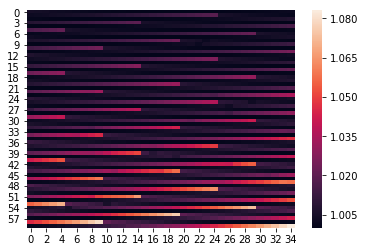

In [16]:
# reshape and make heatmap of aeras.
import seaborn as sns

ax = sns.heatmap((np.array(areas)).reshape(len(lons), len(lats)))
#ax.set_xticklabels(lons)
#ax.set_yticklabels(lats)

In [25]:
lons 

array([-15.  , -14.25, -13.5 , -12.75, -12.  , -11.25, -10.5 ,  -9.75,
        -9.  ,  -8.25,  -7.5 ,  -6.75,  -6.  ,  -5.25,  -4.5 ,  -3.75,
        -3.  ,  -2.25,  -1.5 ,  -0.75,   0.  ,   0.75,   1.5 ,   2.25,
         3.  ,   3.75,   4.5 ,   5.25,   6.  ,   6.75,   7.5 ,   8.25,
         9.  ,   9.75,  10.5 ,  11.25,  12.  ,  12.75,  13.5 ,  14.25,
        15.  ,  15.75,  16.5 ,  17.25,  18.  ,  18.75,  19.5 ,  20.25,
        21.  ,  21.75,  22.5 ,  23.25,  24.  ,  24.75,  25.5 ,  26.25,
        27.  ,  27.75,  28.5 ,  29.25])

In [31]:
xticks

array([-15.  , -12.25,  -9.5 ,  -6.75,  -4.  ,  -1.25,   1.5 ,   4.25,
         7.  ,   9.75,  12.5 ,  15.25,  18.  ,  20.75,  23.5 ,  26.25,
        29.  ])

In [32]:
np.arange()

TypeError: Required argument 'start' (pos 1) not found

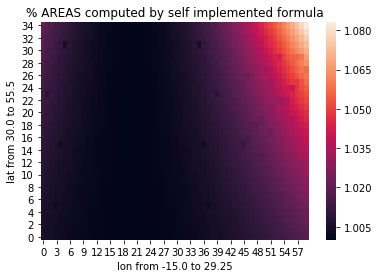

In [36]:
ax = sns.heatmap((np.array(areas)).reshape(len(lats), len(lons)))
ax.invert_yaxis()
ax.set_xlabel("lon from {} to {}".format(min(lons), max(lons)))
ax.set_ylabel("lat from {} to {}".format(min(lats), max(lats)))
#ax.yticklabels(visible = False);
#ax.set_xticklabels(lons);
ax.set_title("% AREAS computed by self implemented formula")
plt.savefig('test_areas.png')

In [ ]:
plt.scatter(c_lon[idx_down_boundary], c_lat[idx_down_boundary])

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_up[idx_left_boundary] > min_lat  )
up_bound  = np.argwhere( cmk_down[idx_left_boundary] < max_lat  )
sub_section_left = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_left

In [ ]:
#  subsection right boundary
low_bound = np.argwhere( cmk_up[idx_right_boundary] > min_lat )
up_bound  = np.argwhere( cmk_down[idx_right_boundary] < max_lat)
sub_section_right = np.intersect1d(low_bound, up_bound)

In [ ]:
sub_section_right

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_up_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_up_boundary] < max_lon  )
sub_section_up = np.intersect1d(low_bound, up_bound)


In [ ]:
sub_section_up

In [ ]:
# subsection left boundary OLD
low_bound = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
up_bound  = np.argwhere( cmk_left[idx_down_boundary] < max_lon  )
sub_section_down = np.intersect1d(low_bound, up_bound)

In [ ]:
up_bound.flatten()

In [ ]:
low_bound.flatten()

In [ ]:
idx_up_boundary

In [ ]:
sub_section_left

In [ ]:
min_lon, max_lon, min_lat, max_lat

In [ ]:
sub_section_down, sub_section_up

In [ ]:
(c_lon[idx_down_boundary] > min_lon).sum()

In [ ]:
( c_lon[idx_down_boundary] < max_lon).sum()

In [ ]:
max_lon

In [ ]:
cmk_left[idx_down_boundary][one].flatten() < -14.

In [ ]:
# Subsection Down Boundary
one = np.argwhere( cmk_right[idx_down_boundary] > min_lon )
two = np.argwhere( cmk_left[idx_down_boundary][one]  < max_lon )

sub_section_down = np.intersect1d(one, two)


In [ ]:
two

In [ ]:
cmk_right[idx_down_boundary][one]

In [ ]:
cmk_left[idx_down_boundary]

In [ ]:
one.flatten()

In [ ]:
two.flatten()

In [ ]:
cmk_left[idx_down_boundary] < max_lon)

In [ ]:
cmk_right[idx_down_boundary][cmk_right[idx_down_boundary] > min_lon] < ma

In [ ]:
sub_section_down

In [ ]:
plt.scatter(c_lon[sub_section_down][sub_section_down], c_lat[sub_section_down][sub_section_down] ) 

In [ ]:

# subsection up boundary
one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
sub_section_up = np.intersect1d(one, two)

In [ ]:
c_lon[idx_left_boundary][sub_section_left], c_lat[idx_left_boundary][sub_section_left]

In [ ]:
c_lon[idx_up_boundary]#[sub_section_up]


In [ ]:
plt.scatter(c_lon[idx_left_boundary][sub_section_left],    c_lat[idx_left_boundary][sub_section_left], label = 'left')
plt.scatter(c_lon[idx_right_boundary][sub_section_right],  c_lat[idx_right_boundary][sub_section_right], label = 'right')
plt.scatter(c_lon[idx_up_boundary][sub_section_up],        c_lat[idx_up_boundary][sub_section_up], label = 'up')
plt.scatter(c_lon[idx_down_boundary][sub_section_down],    c_lat[idx_down_boundary][sub_section_down], label = 'down')
plt.legend()
#plt.scatter([-15.375, 14.625, -15.375, 14.625], [30.375, 30.375, 29.625, 29.625])

In [ ]:
c_lat[idx_left_boundary], c_lon[idx_right_boundary]

In [ ]:
clm_ax = sns.heatmap(cloud_mask)
clm_ax.invert_yaxis()

# index 0,0 is at the lower left corner 

In [ ]:
clm_ax = sns.heatmap(np.flipud(cloud_mask))

In [ ]:
ax = sns.heatmap(lat_array)
ax.set_xlabel('longitude i')
ax.set_ylabel('latitude j')


In [ ]:
ax2 = sns.heatmap(lon_array) # longitude is incleasing with index but latitude is deacreasing.

In [ ]:
compute_area_one_cell(lat = 30, lon = -15, c_lat = lat_array.reshape(-1), 
                      c_lon = lon_array.reshape(-1), d_theta = d_theta.reshape(-1), 
                      d_phi = d_phi.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1))

In [ ]:
area_grid_cell(lat_up, dlat_up, dlon_up).sum()

In [ ]:
area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                  area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA

In [ ]:
lat_array

In [ ]:
sns.heatmap(d_phi)

In [ ]:
sns.heatmap(d_theta)

In [ ]:
coord_info = pd.read_csv('~/Desktop/lat_lon_dlat_dlon.csv')
c_lat = coord_info.lat.values
c_lon = coord_info.lon.values
d_phi_new = coord_info.dlon.values
d_theta_new = coord_info.dlat.values

In [ ]:
d_theta_new.shape

In [ ]:
np.sqrt(10375000)

In [ ]:
sns.heatmap(d_phi.reshape((3712,3712)) )

In [ ]:
sns.heatmap(d_theta.reshape((3712,3712)) )

In [ ]:
#plt.scatter(c_lat.)

In [ ]:
#c_lon[c_lon < -99] = np.nan
#c_lat[c_lat < -99] = np.nan

In [ ]:
#sns.kdeplot(c_lon, c_lat)

In [ ]:
#sns.heatmap(d_phi.reshape((3712, 3712)))

In [ ]:
#sns.heatmap(d_theta.reshape((3712, 3712)))